# Lecture 3: Programming a Matching Decoder
### James R. Wootton, IBM Quantum

## Making an error graph

In [1]:
from decodoku import Decodoku
from qiskit_qec.decoders import DecodingGraph
from retworkx.visualization import mpl_draw

In this lecture we are going to look at how to write a decoder. We'll start with one of the great workhorses of decoding algorithms: minimum weight perfect matching. This has quite broad applicability, but is especially well-suited to things like repetition codes, surface codes and the Decodoku puzzles we've seen so far.

So let's make something to decode.

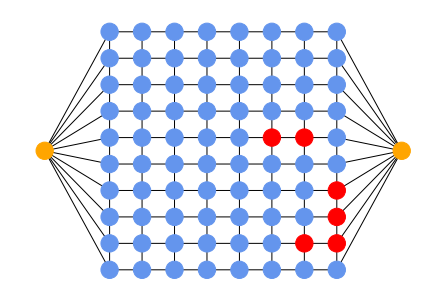

In [2]:
L = 10
p = 0.02

game = Decodoku(L=L, p=p)

game.draw_graph()

Our decoding is, of course, based around the decoding graph. So let's rename it something short and snappy: `dg`.

In [3]:
dg = game.decoding_graph.graph

Most of the decoding graph is actually blank space. The only parts that really interest us are the highlighted nodes. So let's create a new graph that contains only them. We'll call this the 'error graph'.

First, we'll just make a blank `DecodingGraph` object. We'll also give this the short and snappy name of `eg`.

In [4]:
error_graph = DecodingGraph(None)
eg = error_graph.graph

Next we go through all the nodes of `dg` and add only the highlighted ones to `eg`.

We'll also note down their positions. We could use these for the decoding, but here we'll actually just use them for plotting the error graph.

In [5]:
error_pos = []
for n, node in enumerate(dg.nodes()):
    if node['highlighted']:
        eg.add_node(node)
        error_pos.append(game.graph_pos[n])

Let's take a look at our error graph so far.

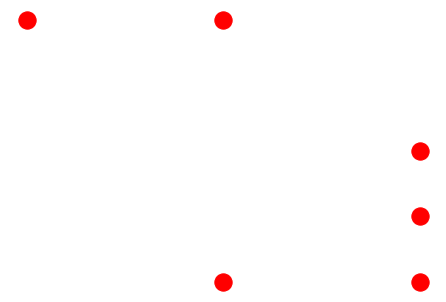

In [6]:
mpl_draw(eg, node_color='red', pos=error_pos)

We have points but no edges. So what edges shall we add? And how to we account for the different distances.

For the latter point, we need to know what those distances are. We could determine these from the positions of the nodes, but this is not always so easy when we have more complex decoding graphs. Instead we can define the distance between two nodes as the number of edges requires to connect them. This makes sense from the perspective of decoding, since it corresponds to the number of errors required to create that pair of highlighted nodes.

Packages made to do graph theory usually have a way of figuring out these distances, and `retworkx` is no different. So we'll just use this.

In [7]:
from retworkx import distance_matrix

distance = distance_matrix(dg)

To get the distance between nodes `0` and `3`, for example, we just use

In [8]:
distance[0][3]

2.0

We don't actually need a fully connected graph. So to experiment with how to keep it simple, we can try putting an upper limit on the distance for which we assign an edge.

In [9]:
d_max = 3

Now let's put in those edges.

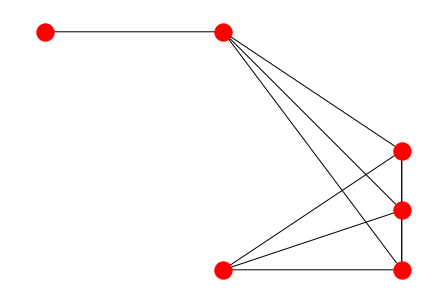

In [10]:
# these lines just repeat what we already did above, to save some effort if we want to rerun the process
error_graph = DecodingGraph(None)
eg = error_graph.graph
error_pos = []
for n, node in enumerate(dg.nodes()):
    if node['highlighted']:
        eg.add_node(node)  
        error_pos.append(game.graph_pos[n])
distance = distance_matrix(dg)


dg_nodes = dg.nodes()
# go through all pairs of nodes in eg
for n0, node0 in enumerate(eg.nodes()):
    for n1, node1 in enumerate(eg.nodes()):
        if n0<n1:
        
            # determine which nodes these are in dg
            dg_n0 = dg_nodes.index(node0)
            dg_n1 = dg_nodes.index(node1)
            # get the distance
            d = distance[dg_n0][dg_n1]
            # and add the edge
            if d<=d_max:
                error_graph.graph.add_edge(n0, n1, {'distance':distance[dg_n0][dg_n1]})
        
mpl_draw(eg, node_color='red', pos=error_pos)

Now we've made a new graph out of just the highlighted nodes. Before we move on, let's note down how many nodes this has.

In [11]:
bulk_node_num = len(eg.nodes())

## Decoding with matching

### Why matching?

Let's think a bit more about what we know of decoding.

Errors create sets of highlighted nodes. Collective properties of these sets of errors also affect certain logical variables that we are interested in. The job of decoding is to figure out how these variables have been affected. Since this cannot be done with certainty, ideally we want to determine *the most likely way* they were affected.

There are often many possible sets of errors that could have caused any given set of higlighted nodes. We can categorize these according to the affect they have on the logical variables. All the sets of errors that cause the same logical effect are said to belong to the same equivalence class. Our job is therefore not to determine the most likely specific set of errors to have occurred, but to determine the most likely equivalence class.

This can be done, but it also can be difficult. Sometimes we need to make compromises. Rather than doing the best possible decoding, we'll do an approximation. And the most obvious approximation is to assume that the most likely equivalence class is the one with the most likely error.

Finding the most likely error is also a pretty complex optimization problem. Many graph-theoretic optimization problems are inefficient to solve. But there are some that do admit an efficient solution: minimum and maximum weight perfect matching.

Put simply, a **matching** is a pairing of the nodes of a graph. The nodes that are paired must be connected by an edge, and no node can be part of more than one pair.

A **perfect matching** is when the nodes become fully paired up, with every node part of a pair.

a **weighted matching** is where we assign a number as a weight to each edge. The total weight of the matching is then the sum of the weights for all the edges that correspond to the pairs.

The minimum and maximum weight matchings are then the matchings with the minimum and maximum total weight, given a particular graph. An algorithm to compute one can also compute the other, because we can simply multiply the weights by $-1$ to turn a minimum weight problem to a maximum weight problem.

This is the precisely the problem we need to solve in order to figure out the most likely set of errors in certain decoding problems. Specifically, those for which errors create pairs of highlighted edges.

Here we will consider the simple case that each error type occurs with equal probability. The most likely set of errors is therefore the one with the least errors. The weight we use is then simply the distance.

# Adding to the error graph

For codes like the Toric code, or repetition codes implemented on a loop, the periodic boundary conditions mean that *all* errors affect pairs of nodes. This means there are no weird boundaries to deal with. But in the case we are looking at now, a there is indeed a weird boundary. This means that isolated highlighted nodes can indeed exist, for which there is obviously no pairing possible. So how are we going to deal with this? The answer is to add more nodes.

For each node we add one additional 'virtual' twin. We associate this with the nearest boundary.

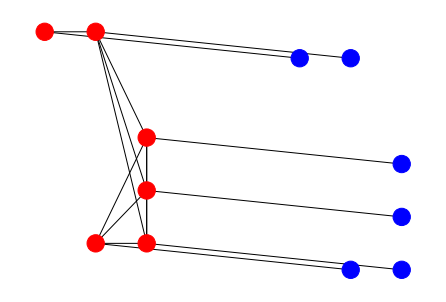

In [12]:
node_color = ['red']*len(eg.nodes())
virtuals = []

for n, node in enumerate(eg.nodes()):
    
    # copy each bulk node and flag up the copy as being on the boundary
    vnode = node.copy()
    vnode['is_boundary'] = True
    
    if node['element']<(L-2)/2:
        # if the node is on the left, also note this
        vnode['boundary'] = 'l'
        d = node['element'] + 1
        # and we place these on the left of any plot
        error_pos.append((node['element']-L/2,-node['time']-0.5))
        node_color.append('green')
    else:
        # similarly for the right
        vnode['boundary'] = 'r'
        d = (L-3) - node['element'] + 1
        error_pos.append((node['element']+L/2,-node['time']-0.5))
        node_color.append('blue')

    # add it to the graph
    nv = eg.add_node(vnode)
    
    # along with an edge, whose distance is of the straight line to the boundary
    eg.add_edge(n, nv, {'distance':d})
    
    # it will be useful to keep track of which virtual nodes are where
    virtuals.append(nv)
        
mpl_draw(eg, node_color=node_color, pos=error_pos)

Now if a highlighted node is associated with the boundary, the matching can pair it with its virtual boundary counterpart.

But what about when the virtual nodes don't need to be used in this way? What will they pair with? To answer this, we connect them up with each other, using edges with weight zero.

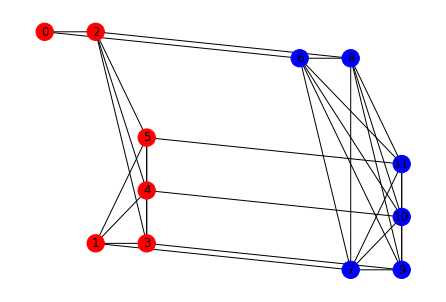

In [13]:
for nv0 in virtuals:
    for nv1 in virtuals:
        if nv0<nv1:
            eg.add_edge(nv0, nv1, {'distance':0})

mpl_draw(eg, node_color=node_color, pos=error_pos, with_labels=True)

Now finally we can find our favourite implementation of the algorithm that find minimum (or maximum) weight matchings and use it.

In [14]:
from retworkx import max_weight_matching

def weight_fn(edge):
    return -int(edge["distance"])

matching = max_weight_matching(eg, max_cardinality=True, weight_fn=weight_fn)

print(matching)

{(6, 11), (2, 0), (10, 7), (4, 5), (9, 8), (1, 3)}


Here is the chosen matching visualized.

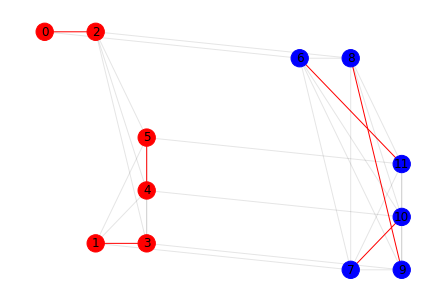

In [15]:
edge_color = []
for edge in eg.edge_list():
    
    if edge in matching or edge[::-1] in matching:
        edge_color.append('red')
    else:
        edge_color.append((0,0,0,0.1))

mpl_draw(eg, node_color=node_color, pos=error_pos, edge_color=edge_color, with_labels=True)

The decoders we write for Decodoku ask us to separate the nodes into clusters, which we think are connected by the same subset of errors. For the matching decoding, these are the pairs that correspond to the minimum weight matching.

We also need to find the boundary correction. This is the parity of the number of times that each boundary (i.e. the virtuals of each boundary) are connected to. This is done by the following (where we use `bc` rather than `boundary_corrections`.

In [16]:
bc = [0,0]
eg_nodes = eg.nodes()
for p, pair in enumerate(matching):
    if pair[0]<bulk_node_num or pair[1]<bulk_node_num:
        for ne in pair:
            node = eg_nodes[ne]
            if node not in dg_nodes:
                if node['boundary']=='l':
                    bc[0] += 1
                else:
                    bc[1] += 1
bc = [bc[0]%2, bc[1]%2]
bc

[0, 0]

And there we have it. All that remains is to paste all the above into one big function to serve as our decoder.

In [17]:
def process(game):
    
    L = game.L
    dg = game.decoding_graph.graph
    
    error_graph = DecodingGraph(None)
    eg = error_graph.graph
    for n, node in enumerate(dg.nodes()):
        if node['highlighted']:
            eg.add_node(node)  
    distance = distance_matrix(dg)

    dg_nodes = dg.nodes()
    # go through all pairs of nodes in eg
    for n0, node0 in enumerate(eg.nodes()):
        for n1, node1 in enumerate(eg.nodes()):
            if n0<n1:

                # determine which nodes these are in dg
                dg_n0 = dg_nodes.index(node0)
                dg_n1 = dg_nodes.index(node1)
                # get the distance
                d = distance[dg_n0][dg_n1]
                # and add the edge
                error_graph.graph.add_edge(n0, n1, {'distance':distance[dg_n0][dg_n1]})

    bulk_node_num = len(eg.nodes())
    
    virtuals = []
    for n, node in enumerate(eg.nodes()):
        # copy each bulk node and flag up the copy as being on the boundary
        vnode = node.copy()
        vnode['is_boundary'] = True
        if node['element']<(L-2)/2:
            # if the node is on the left, also note this
            vnode['boundary'] = 'l'
            d = node['element'] + 1
            # and we place these on the left of any plot
            error_pos.append((node['element']-L/2,-node['time']-2))
            node_color.append('green')
        else:
            # similarly for the right
            vnode['boundary'] = 'r'
            d = (L-3) - node['element'] + 1
            error_pos.append((node['element']+L/2,-node['time']-2))
            node_color.append('blue')
        # add it to the graph
        nv = eg.add_node(vnode)
        # along with an edge, whose distance is of the straight line to the boundary
        eg.add_edge(n, nv, {'distance':d})
        # it will be useful to keep track of which virtual nodes are where
        virtuals.append(nv)
    
    for nv0 in virtuals:
        for nv1 in virtuals:
            if nv0<nv1:
                eg.add_edge(nv0, nv1, {'distance':0})
        
    def weight_fn(edge):
        return -int(edge["distance"])

    matching = max_weight_matching(eg, max_cardinality=True, weight_fn=weight_fn) 
    print(matching)
        
    bc = [0,0]
    clusters = {}
    c = 0
    eg_nodes = eg.nodes()
    for p, pair in enumerate(matching):
        if pair[0]<bulk_node_num or pair[1]<bulk_node_num:
            for ne in pair:
                node = eg_nodes[ne]
                if node in dg_nodes:
                    nd = dg_nodes.index(eg_nodes[ne])
                    clusters[nd] = c
                else:
                    if node['boundary']=='l':
                        bc[0] += 1
                    else:
                        bc[1] += 1
            c += 1
    bc = [bc[0]%2, bc[1]%2]
    
    return bc, clusters

Now let's see how well it works

{(15, 11), (2, 1), (4, 3), (5, 8), (17, 13), (0, 9), (10, 16), (7, 6), (12, 14)}


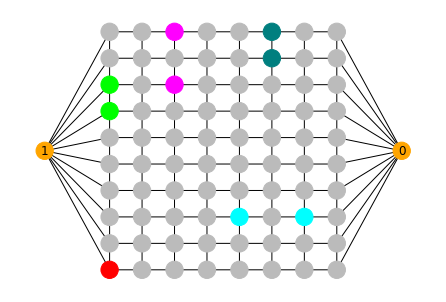

In [18]:
game = Decodoku(L=10, p=0.05, process=process)

game.draw_graph()

In [19]:
game.run()

We can also try it on a few sets of errors we made earlier.

{(4, 0), (3, 7), (1, 2), (5, 6)}


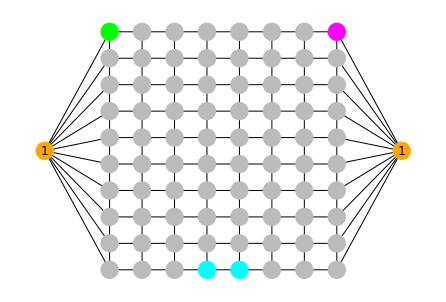

In [20]:
test_errors = [
    [(0,0,1,0), (L-2,0,L-1,0)],
    [((L-2)/2,L-1,(L-2)/2+1,L-1)],
    [(0,0,1,0), (L-2,0,L-1,0), ((L-2)/2,L-1,(L-2)/2+1,L-1)]   
]

game = Decodoku(L=10, p=0.05, process=process, errors=test_errors[2])

game.draw_graph()